In [1]:
import sys
sys.path.append("../rgbd-reg")
from vkitti import vkitti
from skimage import feature

In [2]:
vk = vkitti("/home/matthias/nas-files/", train=True, download=False)

extracting tar ...
extracting tar ...
extracting tar ...
extracting tar ...
loading images...
loading images...
loading params...
loading params...


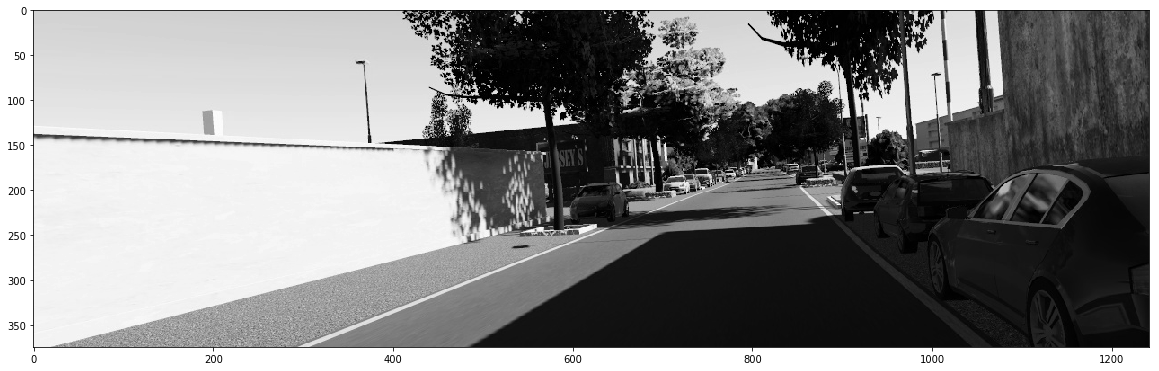

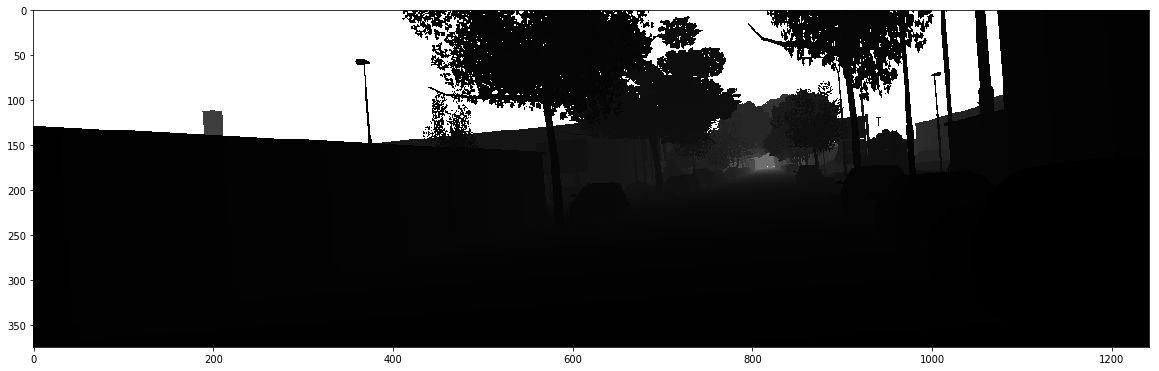

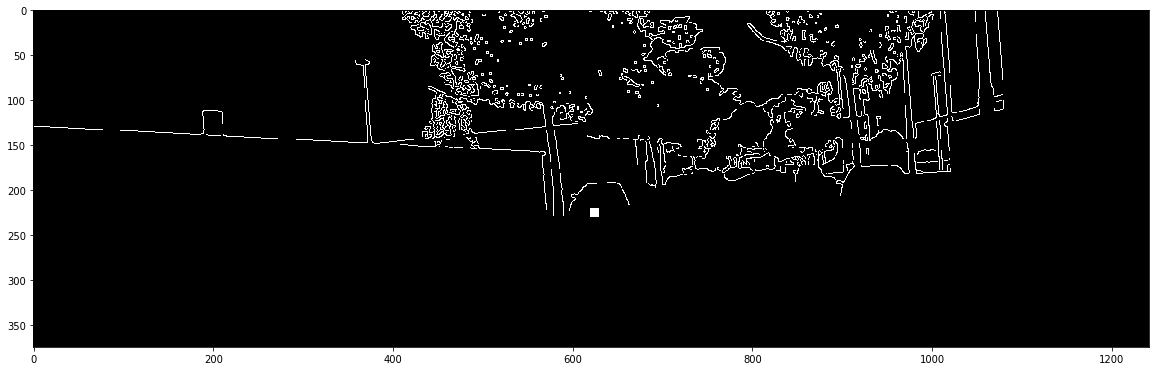

(torch.Size([1, 375, 1242]), torch.Size([1, 375, 1242]), (6,), (18,))

In [3]:
img, dpt, intr, extr = vk[0]

y,x, d = 220, 620, 10

plt.rcParams["figure.figsize"] = (20 , 20)

plt.imshow(img[0], cmap="gray")
plt.show()
plt.imshow(dpt[0], cmap="gray")
plt.show()

canny = feature.canny(dpt[0].numpy())
canny[y:y+d, x:x+d] = 1
plt.imshow(canny, cmap="gray")
plt.show()
img.shape, dpt.shape, intr.shape, extr.shape

In [38]:
def intr_to_K(intr):
    K = np.zeros((3, 4))
    cam, frame, k00, k11, k02, k12 = intr
    K[0,0] = k00
    K[1,1] = k11
    K[0,2] = k02
    K[1,2] = k12
    K[2,2] = 1
    return K

def extr_to_R(extr):   
    frame, cameraID ,r11, r12, r13, t1, r21, r22, r23, t2, r31, r32, r33, t3, z, z, z, o  = extr
    # print("extr_to_R", frame, cameraID)
    RT = np.array([[r11, r12, r13, t1],
                   [r21, r22, r23, t2],
                   [r31, r32, r33, t3],
                   [  0,   0,   0,  1]])
    return RT  

def camera_matr(intr, extr):
    K = intr_to_K(intr)
    RT = extr_to_R(extr)
    M = K @ RT
    return M

def world_for_xyd(im_coord=(x, y), frame_idx=0):
    img, dpt, intr, extr = vk[frame_idx]
    K = intr_to_K(intr)
    ux = K[0,2]
    uy = K[1,2]
    f  = K[0,0]
    
    x, y = im_coord
    world_z = dpt[0, y, x]
    world_x = world_z*(x - ux)/f
    world_y = world_z*(y - uy)/f
    return np.array([world_x, world_y, world_z, 1]) / 100 # cm -> m

def xy_for_world(world_coord, frame_idx):
    _, _, intr, extr = vk[frame_idx]
    M = camera_matr(intr, extr)
    xy = M @ world_coord
    print(xy)
    xy = xy / xy[2]
    return xy

In [26]:
point_3d_id_in_camera_coords_0 = world_for_xyd((620, 220), frame_idx=0) # Nummernschild
point_3d_id_in_camera_coords_2 = world_for_xyd((610, 220), frame_idx=1) # Nummernschild

np.linalg.norm(point_3d_id_in_camera_coords_0 - point_3d_id_in_camera_coords_2)

9.60622187915675e-05

In [39]:
image, depth, intr, extr = vk[0]
RT = extr_to_R(extr)

point_3d_id_in_camera_coords = world_for_xyd((620, 220), frame_idx=0) # Nummernschild
point_3d_id_in_camera_coords

# Reverses camera movement from identity to camera t0
point_3d_id_in_world_coords = np.linalg.pinv(RT) @ point_3d_id_in_camera_coords
point_3d_id_in_world_coords, point_3d_id_in_camera_coords

(array([ 0.00468271, -1.12672297, -0.00643914,  0.01      ]),
 array([ 3.27490561e-06, -2.16143765e-04, -4.74867016e-03,  1.00000000e-02]))

In [40]:
_, _, intr, extr = vk[0]
K = intr_to_K(intr)
RT = extr_to_R(extr)
test_3d_point_in_image = K @ RT @ point_3d_id_in_world_coords
test_3d_point_in_image / test_3d_point_in_image[2]

array([620.        , 219.99999883,   1.        ])

In [35]:
_, _, intr, extr = vk[2]
K = intr_to_K(intr)
RT = extr_to_R(extr)
test_3d_point_in_image = K @ RT @ point_3d_id_in_world_coords
test_3d_point_in_image / test_3d_point_in_image[2]

array([872.78857121, 176.45267999,   1.        ])

In [36]:
point_3d_id_in_world_coords

array([ 0.01417974, -1.1267081 , -0.00651443,  0.01      ])

In [31]:
RT

array([[-8.015394e-03,  6.971319e-02, -9.975349e-01,  6.626684e+00],
       [-1.972947e-03,  9.975639e-01,  6.973107e-02,  1.124692e+02],
       [ 9.999660e-01,  2.527006e-03, -7.858276e-03, -2.832348e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [191]:
R_inv = RT[:3, :3].T
T = RT[:3, 3]
T_inv = -R_inv @ T #, np.linalg.pinv(RT)
RT_inv = np.hstack([R_inv, T_inv.reshape(-1,1)])
RT_inv = np.vstack([RT_inv, [0,0,0,1]])
RT_inv, np.linalg.pinv(RT)

(array([[-7.77924100e-03,  6.94315900e-04,  9.99969400e-01,
          2.07272032e+00],
        [ 7.30738000e-02,  9.97326600e-01, -1.24000000e-04,
         -1.12649982e+02],
        [-9.97296200e-01,  7.30706100e-02, -7.80916200e-03,
         -9.66625725e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[-7.77922443e-03,  6.94309888e-04,  9.99969601e-01,
          2.07272130e+00],
        [ 7.30737979e-02,  9.97326457e-01, -1.24004727e-04,
         -1.12649966e+02],
        [-9.97296193e-01,  7.30706011e-02, -7.80918047e-03,
         -9.66624821e-01],
        [-6.64615932e-17, -9.54097912e-17,  8.48659251e-17,
          1.00000000e+00]]))

In [45]:
(extr_to_R(vk[0][3]),
 extr_to_R(vk[1][3]),
 extr_to_R(vk[2][3]),
 extr_to_R(vk[3][3]),)

(array([[-8.019686e-03,  7.217909e-02, -9.973595e-01,  7.494453e+00],
        [-9.896867e-04,  9.973904e-01,  7.218930e-02,  1.124036e+02],
        [ 9.999674e-01,  1.566000e-03, -7.927299e-03, -7.717823e-01],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]),
 array([[-7.779241e-03,  7.307380e-02, -9.972962e-01,  7.283874e+00],
        [ 6.943159e-04,  9.973266e-01,  7.307061e-02,  1.124180e+02],
        [ 9.999694e-01, -1.240000e-04, -7.809162e-03, -2.094175e+00],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]),
 array([[-8.015394e-03,  6.971319e-02, -9.975349e-01,  6.626684e+00],
        [-1.972947e-03,  9.975639e-01,  6.973107e-02,  1.124692e+02],
        [ 9.999660e-01,  2.527006e-03, -7.858276e-03, -2.832348e+00],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]),
 array([[-8.151174e-03,  6.922305e-02, -9.975680e-01,  6.289214e+00],
        [-6.129198e-03,  9.975789e-01,  6.927389e-02,  1.125098e+02],
        [ 9.99

In [83]:
intr_to_K(intr), extr_to_R(extr), camera_matr(intr, extr)

[  7.494453  112.4036     -0.7717823   1.       ]
[  7.494453  112.4036     -0.7717823   1.       ]


(array([[725.0087,   0.    , 620.5   ,   0.    ],
        [  0.    , 725.0087, 187.    ,   0.    ],
        [  0.    ,   0.    ,   1.    ,   0.    ]]),
 array([[-8.019686e-03,  7.217909e-02, -9.973595e-01,  7.494453e+00],
        [-9.896867e-04,  9.973904e-01,  7.218930e-02,  1.124036e+02],
        [ 9.999674e-01,  1.566000e-03, -7.927299e-03, -7.717823e-01],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]),
 array([[ 6.14665430e+02,  5.33021712e+01, -7.28013204e+02,
          4.95465271e+03],
        [ 1.86276372e+02,  7.23409559e+02,  5.08554656e+01,
          8.13492646e+04],
        [ 9.99967400e-01,  1.56600000e-03, -7.92729900e-03,
         -7.71782300e-01]]))

[array([-1.57377410e+00,  1.03869095e+02,  2.28200000e+03,  1.00000000e+00]),
 array([-1.49584401e+00,  9.87257080e+01,  2.16900000e+03,  1.00000000e+00]),
 array([-1.43722403e+00,  9.48567886e+01,  2.08400000e+03,  1.00000000e+00]),
 array([-1.40550029e+00,  9.27630234e+01,  2.03800000e+03,  1.00000000e+00]),
 array([-1.40894854e+00,  9.29906082e+01,  2.04300000e+03,  1.00000000e+00]),
 array([-1.40205204e+00,  9.25354385e+01,  2.03300000e+03,  1.00000000e+00]),
 array([-2.10618162e+00,  1.39007980e+02,  3.05400000e+03,  1.00000000e+00]),
 array([-2.15169835e+00,  1.42012085e+02,  3.12000000e+03,  1.00000000e+00]),
 array([-2.18066335e+00,  1.43923782e+02,  3.16200000e+03,  1.00000000e+00]),
 array([-2.19514608e+00,  1.44879639e+02,  3.18300000e+03,  1.00000000e+00]),
 array([-2.15583611e+00,  1.42285187e+02,  3.12600000e+03,  1.00000000e+00]),
 array([-2.12411237e+00,  1.40191422e+02,  3.08000000e+03,  1.00000000e+00])]

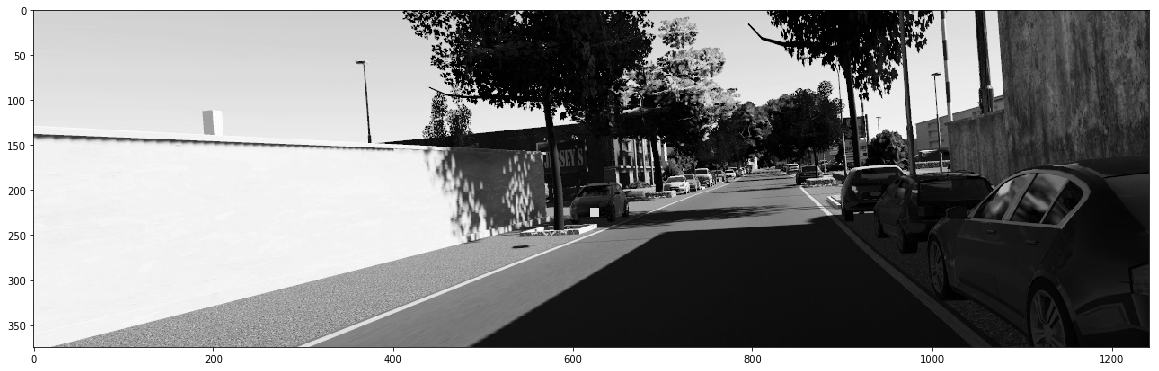

In [87]:
y,x, d = 220, 620, 10

img, dpt, intr, extr = vk[0]
img = img.clone()
img[0, y:y+d, x:x+d] = 1
plt.imshow(img[0], cmap="gray")

world_coords = [world_for_xyd((x, y), frame_idx=0),  
                world_for_xyd((x, y), frame_idx=1), 
                world_for_xyd((x, y), frame_idx=2), 
                world_for_xyd((x, y), frame_idx=3), 
                world_for_xyd((x, y), frame_idx=4), 
                world_for_xyd((x, y), frame_idx=5), 
                world_for_xyd((x, y), frame_idx=6), 
                world_for_xyd((x, y), frame_idx=7), 
                world_for_xyd((x, y), frame_idx=8), 
                world_for_xyd((x, y), frame_idx=9), 
                world_for_xyd((x, y), frame_idx=10), 
                world_for_xyd((x, y), frame_idx=11)]

world_coords

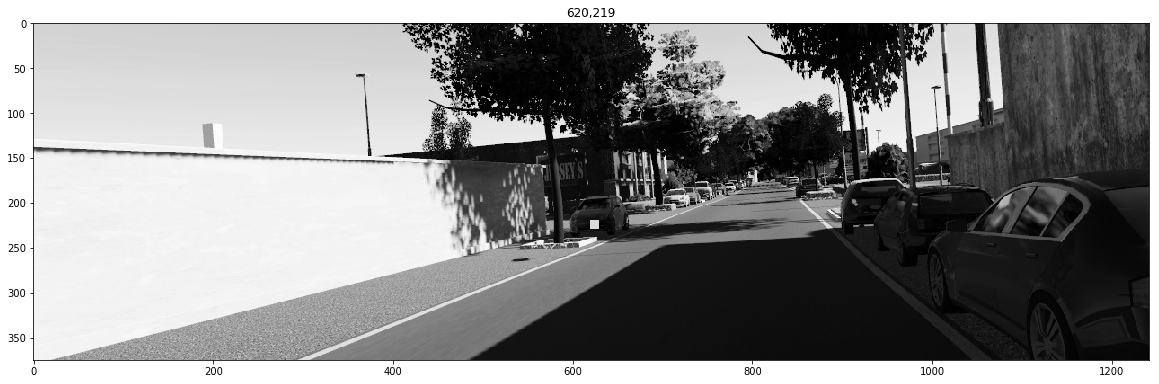

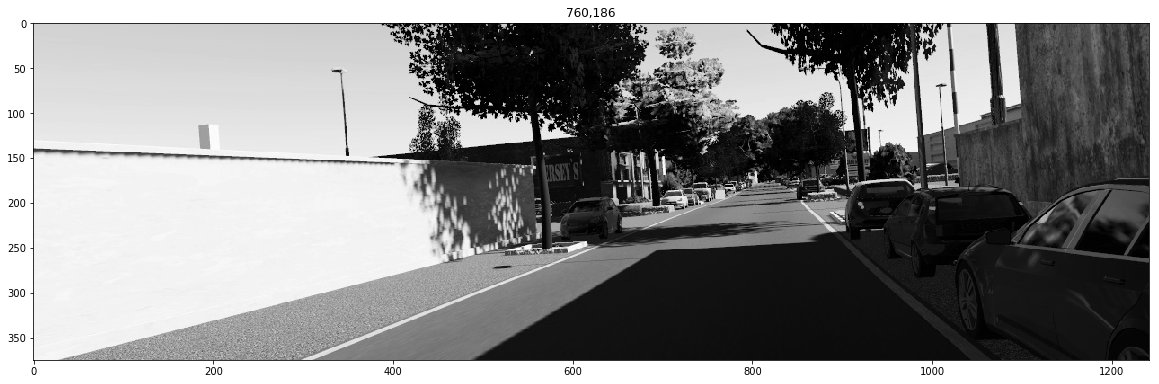

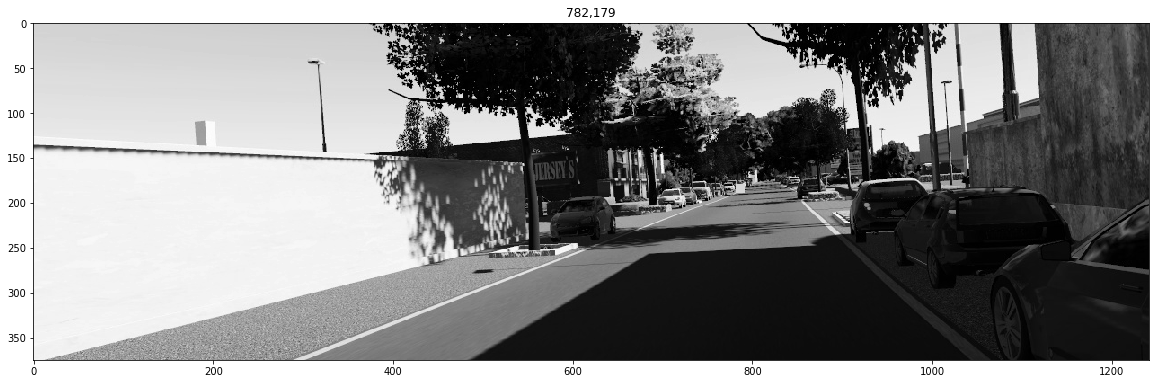

In [13]:
coo = 0

idx = 0
img, _, intr, extr = vk[idx]
K = intr_to_K(intr)
RT = extr_to_R(extr)
test_3d_point_in_image = K @ RT @ point_3d_id_in_world_coords
test_3d_point_in_image = test_3d_point_in_image / test_3d_point_in_image[2]
x, y = int(test_3d_point_in_image[0]), int(test_3d_point_in_image[1])
iimg = img[0].clone()
iimg[y:y+d, x:x+d] = 1
plt.imshow(iimg, cmap="gray")
plt.title(f"{x},{y}")
plt.show()

idx = 1
img, _, intr, extr = vk[idx]
K = intr_to_K(intr)
RT = extr_to_R(extr)
test_3d_point_in_image = K @ RT @ point_3d_id_in_world_coords
test_3d_point_in_image = test_3d_point_in_image / test_3d_point_in_image[2]
x, y = int(test_3d_point_in_image[0]), int(test_3d_point_in_image[1])
iimg = img[0].clone()
iimg[y:y+d, x:x+d] = 1
plt.imshow(iimg, cmap="gray")
plt.title(f"{x},{y}")
plt.show()

idx = 2
img, _, intr, extr = vk[idx]
K = intr_to_K(intr)
RT = extr_to_R(extr)
test_3d_point_in_image = K @ RT @ point_3d_id_in_world_coords
test_3d_point_in_image = test_3d_point_in_image / test_3d_point_in_image[2]
x, y = int(test_3d_point_in_image[0]), int(test_3d_point_in_image[1])
iimg = img[0].clone()
iimg[y:y+d, x:x+d] = 1
plt.imshow(iimg, cmap="gray")
plt.title(f"{x},{y}")
plt.show()